# **ML Modeling and Evaluation - Classification A**

## Objectives

* Fit a feature engineering pipeline
* Fit a classification model to predict the health risk level of patients
* Perform hyperparameter optimization
* Evaluate the classification model performance
  
## Inputs

* Cleaned Maternal Health Risks dataset: outputs/cleaned/maternal-health-risk-dataset-clean.csv
* Instructions on feature engineering steps to take (see previous notebook)

## Outputs

All outputs are with all features considered:

* Train set (features and target)
* Test set (features and target)
* Feature engineering pipeline
* Modeling pipeline (fitted with all features)

## Additional Comments
* This is the first part of the modeling and evaluation - classification notebooks with the main result being a feature engineering and modeling pipeline (which was fit with all features).
* See part B of this notebook for the rest of the analysis (feature selection and refitting with best features only).
* The outputs from this notebook are not used in the final dashboard but are saved as interim results for further study in part B of the notebook.
* The grid search for the best algorithm is long since we consider three models and further study them to find the best one.
* Then we analyse three different hyperparameter optimization searches on this best model to find the balance between performance and generalizability before deciding on a best model with best hyperparameters.

---

# Import Packages for Modelling and Evaluation

In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# feature engineering
from feature_engine import transformation as vt
from feature_engine.selection import SmartCorrelatedSelection
from feature_engine.outliers import Winsorizer

# pipeline
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
# to save pipeline to outputs
import joblib

# scaling
from sklearn.preprocessing import StandardScaler

# feauture selection
from sklearn.feature_selection import SelectFromModel

# ML algorithms
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier

# grid search
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import SMOTE
from sklearn.metrics import make_scorer, recall_score

# Evaluation
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay  # noqa

%matplotlib inline

# Change working directory

We need to change the working directory from its current folder to its parent folder
* Access current directory with os.getcwd()

In [2]:
current_dir = os.getcwd()
current_dir

'/workspaces/ML-maternal-health-risk/jupyter_notebooks'

Make the parent of the current directory the new current directory, and confirm new current directory
* os.path.dirname() gets the parent directory
* os.chir() defines the new current directory
* os.getcwd() get the current directory

In [3]:
os.chdir(os.path.dirname(current_dir))
current_dir = os.getcwd()
print(f"New current directory set to {current_dir}.")

New current directory set to /workspaces/ML-maternal-health-risk.


# Step 1: Load Data

Recall that we can directly load the cleaned dataset, since the only data cleaning we had to do was to remove 3 (suspectedly) erronous datapoints. There were no steps that could be performed in a data cleaning pipeline.

In [4]:
df = pd.read_csv(
        'outputs/datasets/cleaned/maternal-health-risk-dataset-clean.csv'
        )
print(df.shape)
df.head()

(1011, 7)


,Age,SystolicBP,DiastolicBP,BloodSugar,BodyTemp,HeartRate,RiskLevel
0,25,130,80,15.0,36.7,86,2
1,35,140,90,13.0,36.7,70,2
2,29,90,70,8.0,37.8,80,2
3,30,140,85,7.0,36.7,70,2
4,35,120,60,6.1,36.7,76,0


---

# Step 2: ML pipeline with all Data

## ML Pipeline for Feature Engineering

In this section we will implement the ML pipeline for feature engineering. Recall that we do not need a DataCleaning Pipeline in this project due to an already clean dataset.

We implement a pipeline including the following steps:

* Outlier handling: Winsorizer for `["BloodSugar", "SystolicBP"]`
* Numerical Transformations: Box-Cox transformation for `["Age", "SystolicBP", "BloodSugar"]`
* SmartCorrelatedSelection (which will drop `["DiastolicBP"]`)

Define the feature engineering pipeline and call it

In [5]:
def PipelineFeatureEngineering():
    """
    Defines a pipeline including the feature engineering steps from above
    Winsorizer
    Box-Cox transformation
    SmartCorrelatedSelection
    """
    pipeline_base = Pipeline([
        ("Winsorizer", Winsorizer(
                            capping_method='iqr',
                            tail='both',
                            fold=1.5,
                            variables=["BloodSugar", "SystolicBP"]
                            )),
        ("BoxCoxTransformation", vt.BoxCoxTransformer(variables=[
                                                    "Age",
                                                    "SystolicBP",
                                                    "BloodSugar"
                                                    ])),
        ("SmartCorrelatedSelection", SmartCorrelatedSelection(
                                        variables=None,
                                        method="spearman",
                                        threshold=0.6,
                                        selection_method="variance"
                                        )),
    ])

    return pipeline_base


PipelineFeatureEngineering()

Pipeline(steps=[('Winsorizer',
                 Winsorizer(capping_method='iqr', fold=1.5, tail='both',
                            variables=['BloodSugar', 'SystolicBP'])),
                ('BoxCoxTransformation',
                 BoxCoxTransformer(variables=['Age', 'SystolicBP',
                                              'BloodSugar'])),
                ('SmartCorrelatedSelection',
                 SmartCorrelatedSelection(method='spearman',
                                          selection_method='variance',
                                          threshold=0.6))])

## ML Pipeline for Modelling and Hyperparameter Optimization

Define a pipeline that handles the ML Classifier modelling. It also includes feature scaling and feature selection which both need to happen after the feature engineering step.
We choose the StandardScaler to scale our features and the SelectFromModel to select the most important features to train the model.

In [6]:
def PipelineClassifier(model):
    pipeline_base = Pipeline([
        ("scaler", StandardScaler()),
        ("feat_selection", SelectFromModel(model)),
        ("model", model),
    ])

    return pipeline_base

Next, we will conduct a hyperparameter optimization search to get the classification model as well as the hyperparameters that fit our dataset the best.

We start with a custom class for an efficient hyperparameter optimisation as well as algorithm search.

In [7]:
# The code for this class is from the Code Institute churnometer
# walkthrough project


class HyperparameterOptimizationSearch:
    """
    Creates an instance of HyperparameterOptimizationSearch
    """
    def __init__(self, models, params):
        self.models = models
        self.params = params
        self.keys = models.keys()
        self.grid_searches = {}

    def fit(self, X, y, cv, n_jobs, verbose=1, scoring=None, refit=False):
        """
        Fits the models to the data for each model and hyperparameters
        """
        for key in self.keys:
            print(f"\nRunning GridSearchCV for {key} \n")

            model = PipelineClassifier(self.models[key])
            params = self.params[key]
            gs = GridSearchCV(
                    model,
                    params,
                    cv=cv,
                    n_jobs=n_jobs,
                    verbose=verbose,
                    scoring=scoring
                    )
            gs.fit(X, y)
            self.grid_searches[key] = gs

    def score_summary(self, sort_by='mean_score'):
        """
        Collects the performance scores and stores in a dataframe
        """
        def row(key, scores, params):
            d = {
                'estimator': key,
                'min_score': min(scores),
                'max_score': max(scores),
                'mean_score': np.mean(scores),
                'std_score': np.std(scores),
                }
            return pd.Series({**params, **d})

        rows = []
        for k in self.grid_searches:
            params = self.grid_searches[k].cv_results_['params']
            scores = []
            for i in range(self.grid_searches[k].cv):
                key = "split{}_test_score".format(i)
                r = self.grid_searches[k].cv_results_[key]
                scores.append(r.reshape(len(params), 1))

            all_scores = np.hstack(scores)
            for p, s in zip(params, all_scores):
                rows.append((row(k, s, p)))

        df = pd.concat(rows, axis=1).T.sort_values([sort_by], ascending=False)
        columns = [
                    'estimator',
                    'min_score',
                    'mean_score',
                    'max_score',
                    'std_score'
                    ]
        columns = columns + [c for c in df.columns if c not in columns]
        return df[columns], self.grid_searches


### 1. Split into Train and Test Set

Before getting into the hyperparameter optimisation we need to split our dataset into train and test set

In [8]:
X_train, X_test, y_train, y_test = train_test_split(
                                        df.drop(['RiskLevel'], axis=1),
                                        df['RiskLevel'],
                                        test_size=0.2,
                                        random_state=0,
                                        )

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(808, 6) (808,) (203, 6) (203,)


### 2. Fit Feature Engineering Pipeline to Train Set

In [9]:

# Create feature engineering pipeline
pipeline_feat_eng = PipelineFeatureEngineering()

# fit on the train set and transform train set
X_train = pipeline_feat_eng.fit_transform(X_train)
# transform the test set
X_test = pipeline_feat_eng.transform(X_test)

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(808, 5) (808,) (203, 5) (203,)


### 3. Handle Target Imbalance

As mentioned in the data collection notebook the RiskLevel target column is moderately imbalanced. To improve model performance we perform SMOTE (Synthetic Minority Oversamplin Technique) to balance the train set by creating synthetic data. Importantly, we do this after fitting the feature engineering pipeline.

Plot the target distribution from the train set:

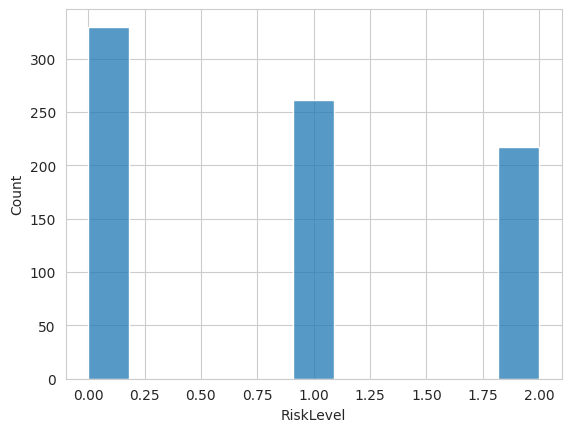

In [10]:
sns.set_style("whitegrid")
sns.histplot(data=y_train)
plt.show()

In [11]:
y_train.value_counts()

RiskLevel
0    330
1    261
2    217
Name: count, dtype: int64

**Resample the dataset with SMOTE**

The sample is slightly imbalanced with RiskLevel counts:
* low-risk (0): 330
* mid-risk (1): 261
* high-risk (2): 217

We decide to take a moderate oversampling approach of resampling both mid-risk and high-risk to 300. This is because, even though a totally balanced dataset might be advantageous for the classifier models, there is a risk of overfitting the models. Since our dataset is relatively small, generating too much synthetic high-risk data might overfit our model towards high-risk.

Fit and resample the test set:

In [12]:
# Create SMOTE object

oversample = SMOTE(
                sampling_strategy={1: 300, 2: 300},
                random_state=0
                )

# fit oversample to train set and resample the train set
X_train, y_train = oversample.fit_resample(X_train, y_train)

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(930, 5) (930,) (203, 5) (203,)


Check the target distibution for the train set again after resampling. It is now more balanced but purposefully not completely balanced.

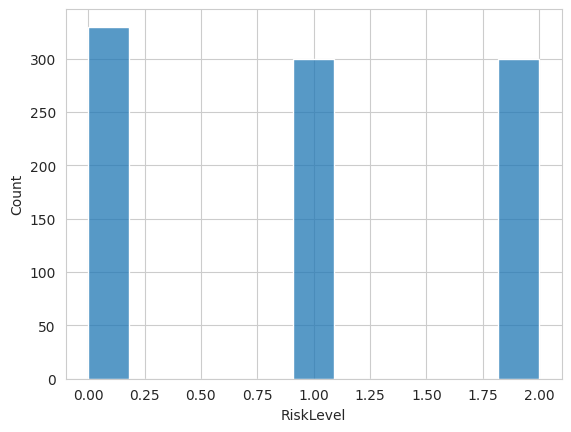

In [13]:
sns.set_style("whitegrid")
sns.histplot(data=y_train)
plt.show()

### 4. Grid Search to find best Algorithm

We use Grid Search CV to conduct a hypermarameter optimisation search. The first step is to focus on finding the most suitable algorithm before optimizing its hyperparameters.

So let us first search through many different classification algorithms using only their standard hyperparameters for efficiency. Next, we will choose the best algorithm and conduct an extensive hyperparameter optimisation search on this specific algorithm (or several good ones).

In [14]:
models_quick_search = {
    "LogisticRegression": LogisticRegression(random_state=0),
    "DecisionTreeClassifier": DecisionTreeClassifier(random_state=0),
    "RandomForestClassifier": RandomForestClassifier(random_state=0),
    "AdaBoostClassifier": AdaBoostClassifier(random_state=0),
    "ExtraTreesClassifier": ExtraTreesClassifier(random_state=0),
    "GradientBoostingClassifier": GradientBoostingClassifier(random_state=0),
    "XGBClassifier": XGBClassifier(random_state=0),
}

params_quick_search = {
    "LogisticRegression": {},
    "DecisionTreeClassifier": {},
    "RandomForestClassifier": {},
    "AdaBoostClassifier": {},
    "ExtraTreesClassifier": {},
    "GradientBoostingClassifier": {},
    "XGBClassifier": {},
}

We perform the grid search with the goal to optimize for the recall of high-risk level predictions as stated in the business case.

In [15]:
quick_search_hr = HyperparameterOptimizationSearch(
                    models=models_quick_search,
                    params=params_quick_search
                    )
quick_search_hr.fit(
                X_train,
                y_train,
                scoring=make_scorer(recall_score, labels=[2], average=None),
                n_jobs=-1,
                cv=5
                )


Running GridSearchCV for LogisticRegression 

Fitting 5 folds for each of 1 candidates, totalling 5 fits



Running GridSearchCV for DecisionTreeClassifier 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for RandomForestClassifier 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for AdaBoostClassifier 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for ExtraTreesClassifier 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for GradientBoostingClassifier 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for XGBClassifier 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


In [16]:
grid_search_summary_hr, grid_search_pipelines_hr = quick_search_hr.score_summary(sort_by='mean_score')  # noqa
grid_search_summary_hr.head()

,estimator,min_score,mean_score,max_score,std_score
3,AdaBoostClassifier,0.783333,0.876667,0.933333,0.050111
2,RandomForestClassifier,0.733333,0.87,0.933333,0.073333
5,GradientBoostingClassifier,0.733333,0.823333,0.866667,0.051208
6,XGBClassifier,0.75,0.82,0.9,0.05099
4,ExtraTreesClassifier,0.733333,0.813333,0.866667,0.05416


To avoid biasing the model towards only the high-risk level recall, we also perform a grid search optimizing for the recall averaged over all three classes and compare the results. Note that we choose the unweighted macro average here, since we do not want to put more emphasis on low-risk which is the heaviest class.

In [17]:
quick_search_ave = HyperparameterOptimizationSearch(
                        models=models_quick_search,
                        params=params_quick_search
                        )
quick_search_ave.fit(
                X_train,
                y_train,
                scoring=make_scorer(recall_score, average="macro"),
                n_jobs=-1,
                cv=5)


Running GridSearchCV for LogisticRegression 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for DecisionTreeClassifier 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for RandomForestClassifier 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for AdaBoostClassifier 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for ExtraTreesClassifier 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for GradientBoostingClassifier 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for XGBClassifier 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


In [18]:
grid_search_summary_ave, grid_search_pipelines_ave = quick_search_ave.score_summary(sort_by='mean_score')  # noqa
grid_search_summary_ave.head()

,estimator,min_score,mean_score,max_score,std_score
2,RandomForestClassifier,0.65404,0.784949,0.839899,0.069166
4,ExtraTreesClassifier,0.659091,0.713232,0.762626,0.033576
5,GradientBoostingClassifier,0.664141,0.710404,0.741414,0.027154
6,XGBClassifier,0.664646,0.708182,0.720707,0.021846
1,DecisionTreeClassifier,0.595455,0.70101,0.795455,0.069823


AdaBoost shows the best performance when we optimize for high-risk recall only, but is much weaker when looking at all classes, which could be a sign that the model is not well suited for predicting health risk levels. Even though it has good recall on high-risk we still need a reasonably high performance on the other classes as well. RandomForestClassifier is the second best performer when optimizing for high-risk recall and best performer when optimizing for averaged recall. Thus, we will take these two algorithms into the next round of more extensive hyperparameter search.
The runner up in the averaged recall optimization is ExtraTreesClassifier, however its performance is significantly lower than RandomForestClassier and hence, it is not worth it to consider it further.

In [19]:
models_search = {
    "RandomForestClassifier": RandomForestClassifier(random_state=0),
    "AdaBoostClassifier": AdaBoostClassifier(random_state=0),
}

# Conduct an extensive hyperparameter search:
# We get inspiration for common and useful hyperparameter values from
# the Code Institute course and from the algorithms' documentations
params_search = {
    "RandomForestClassifier": {
        'model__n_estimators': [100, 50, 140],
        'model__max_depth': [None, 4, 8, 12, 15],
        'model__min_samples_split': [2, 5, 50],
        'model__min_samples_leaf': [1, 5, 50],
        'model__max_leaf_nodes': [None, 10, 50]
    },
    "AdaBoostClassifier": {
        'model__n_estimators': [50, 25, 80, 150],
        'model__learning_rate': [1, 0.1, 2]
    }
}

Start with the optimization for high-risk level recall again.

In [20]:
search_hr = HyperparameterOptimizationSearch(
                models=models_search,
                params=params_search
                )
search_hr.fit(
            X_train,
            y_train,
            scoring=make_scorer(recall_score, labels=[2], average=None),
            n_jobs=-1,
            cv=5
            )


Running GridSearchCV for RandomForestClassifier 

Fitting 5 folds for each of 405 candidates, totalling 2025 fits

Running GridSearchCV for AdaBoostClassifier 

Fitting 5 folds for each of 12 candidates, totalling 60 fits


In [21]:
grid_search_summary_hr, grid_search_pipelines_hr = search_hr.score_summary(sort_by='mean_score')  # noqa
grid_search_summary_hr.head()

,estimator,min_score,mean_score,max_score,std_score,model__max_depth,model__max_leaf_nodes,model__min_samples_leaf,model__min_samples_split,model__n_estimators,model__learning_rate
406,AdaBoostClassifier,0.783333,0.876667,0.933333,0.050111,NaN,NaN,NaN,NaN,25,1
405,AdaBoostClassifier,0.783333,0.876667,0.933333,0.050111,NaN,NaN,NaN,NaN,50,1
199,RandomForestClassifier,0.816667,0.873333,0.916667,0.035901,8,10,5,2,50,NaN
203,RandomForestClassifier,0.816667,0.873333,0.916667,0.035901,8,10,5,5,140,NaN
353,RandomForestClassifier,0.816667,0.873333,0.916667,0.035901,15,10,1,2,140,NaN


Now optimize for macro averaged recall for all three classes.

In [22]:
search_ave = HyperparameterOptimizationSearch(
                models=models_search,
                params=params_search
                )
search_ave.fit(
                X_train,
                y_train,
                scoring=make_scorer(recall_score, average="macro"),
                n_jobs=-1,
                cv=5)


Running GridSearchCV for RandomForestClassifier 

Fitting 5 folds for each of 405 candidates, totalling 2025 fits

Running GridSearchCV for AdaBoostClassifier 

Fitting 5 folds for each of 12 candidates, totalling 60 fits


In [23]:
grid_search_summary_ave, grid_search_pipelines_ave = search_ave.score_summary(sort_by='mean_score')  # noqa
grid_search_summary_ave.head()

,estimator,min_score,mean_score,max_score,std_score,model__max_depth,model__max_leaf_nodes,model__min_samples_leaf,model__min_samples_split,model__n_estimators,model__learning_rate
325,RandomForestClassifier,0.65404,0.78596,0.845455,0.068765,15,None,1,2,50,NaN
324,RandomForestClassifier,0.65404,0.785051,0.845455,0.068393,15,None,1,2,100,NaN
0,RandomForestClassifier,0.65404,0.784949,0.839899,0.069166,None,None,1,2,100,NaN
1,RandomForestClassifier,0.65404,0.784848,0.839899,0.068672,None,None,1,2,50,NaN
243,RandomForestClassifier,0.65404,0.784848,0.845455,0.068118,12,None,1,2,100,NaN


To come to a decision, we will look at the three best models in more detail and compute the performance metrics for all three of them. Based on the confusion matrices and performance scores we will decide which model to study further.

We continue with:
* AdaBoostClassifier with best results for high-risk recall (mean score 0.88)
* RandomForestClassifier with best results for high-risk recall (mean score 0.87)
* RandomForestClassifier with best results for averaged recall (mean score 0.79)

#### Get models programmatically:

Best model for averaged recall

In [24]:
best_model_ave = grid_search_summary_ave.iloc[0, 0]
best_model_ave

'RandomForestClassifier'

Best AdaBoost model for high-risk recall

In [25]:
best_model_hr_ada = grid_search_summary_hr.iloc[0, 0]
best_model_hr_ada

'AdaBoostClassifier'

Best RandomForest model for high-risk recall

In [26]:
best_model_hr_rf = grid_search_summary_hr.iloc[2, 0]
best_model_hr_rf

'RandomForestClassifier'

Get the best parameters for each model

In [27]:
best_parameters_ave = grid_search_pipelines_ave[best_model_ave].best_params_
best_parameters_ave

{'model__max_depth': 15,
 'model__max_leaf_nodes': None,
 'model__min_samples_leaf': 1,
 'model__min_samples_split': 2,
 'model__n_estimators': 50}

In [28]:
best_parameters_hr_ada = grid_search_pipelines_hr[best_model_hr_ada].best_params_  # noqa
best_parameters_hr_ada

{'model__learning_rate': 1, 'model__n_estimators': 50}

In [29]:
best_parameters_hr_rf = grid_search_pipelines_hr[best_model_hr_rf].best_params_
best_parameters_hr_rf

{'model__max_depth': None,
 'model__max_leaf_nodes': 10,
 'model__min_samples_leaf': 1,
 'model__min_samples_split': 2,
 'model__n_estimators': 50}

Define the best clf pipeline (optimized for recall averaged over the three classes).

In [30]:
pipeline_clf_ave = grid_search_pipelines_ave[best_model_ave].best_estimator_
pipeline_clf_ave

Pipeline(steps=[('scaler', StandardScaler()),
                ('feat_selection',
                 SelectFromModel(estimator=RandomForestClassifier(random_state=0))),
                ('model',
                 RandomForestClassifier(max_depth=15, n_estimators=50,
                                        random_state=0))])

Define the best clf AdaBoost pipeline (optimized for recall for high-risk level).

In [31]:
pipeline_clf_hr_ada = grid_search_pipelines_hr[best_model_hr_ada].best_estimator_  # noqa
pipeline_clf_hr_ada

Pipeline(steps=[('scaler', StandardScaler()),
                ('feat_selection',
                 SelectFromModel(estimator=AdaBoostClassifier(random_state=0))),
                ('model', AdaBoostClassifier(learning_rate=1, random_state=0))])

Define the best clf RandomForest pipeline (optimized for recall for high-risk level).

In [32]:
pipeline_clf_hr_rf = grid_search_pipelines_hr[best_model_hr_rf].best_estimator_
pipeline_clf_hr_rf

Pipeline(steps=[('scaler', StandardScaler()),
                ('feat_selection',
                 SelectFromModel(estimator=RandomForestClassifier(random_state=0))),
                ('model',
                 RandomForestClassifier(max_leaf_nodes=10, n_estimators=50,
                                        random_state=0))])

### 5. Evaluate Pipelines on Train and Test Sets to find Best Algorithm

We evaluate the three classifier pipelines on the train and the test set to decide which one is best suitable for our project.

Custom function for performance report and confusion matrix printing:

In [33]:
# Code for these functions was taken from the Code Institute
# Churnometer walkthrough project

def confusion_matrix_and_report(X, y, pipeline, label_map):
    """
    Computes and prints confusion matrix and classification report
    """
    prediction = pipeline.predict(X)

    print('---  Confusion Matrix  ---')
    print(pd.DataFrame(
                confusion_matrix(y_true=prediction, y_pred=y),
                columns=[["Actual " + sub for sub in label_map]],
                index=[["Prediction " + sub for sub in label_map]]
                ))
    print("\n")

    print('---  Classification Report  ---')
    print(classification_report(y, prediction, target_names=label_map), "\n")


def clf_performance(X_train, y_train, X_test, y_test, pipeline, label_map):
    """
    Prints performance summary for train and test set
    """
    print("#### Train Set #### \n")
    confusion_matrix_and_report(X_train, y_train, pipeline, label_map)

    print("#### Test Set ####\n")
    confusion_matrix_and_report(X_test, y_test, pipeline, label_map)


Metrics defined in the business case:
* Recall for high-risk should be at least 80%
* Precision for low-risk should be at least 80%

Test RandomForestClassifier optimized for averaged recall:

In [34]:

clf_performance(
        X_train=X_train,
        y_train=y_train,
        X_test=X_test,
        y_test=y_test,
        pipeline=pipeline_clf_ave,
        label_map=['low risk', 'mid risk', 'high risk']
        )

#### Train Set #### 

---  Confusion Matrix  ---
                     Actual low risk Actual mid risk Actual high risk
Prediction low risk              292              16                3
Prediction mid risk               34             271                8
Prediction high risk               4              13              289


---  Classification Report  ---
              precision    recall  f1-score   support

    low risk       0.94      0.88      0.91       330
    mid risk       0.87      0.90      0.88       300
   high risk       0.94      0.96      0.95       300

    accuracy                           0.92       930
   macro avg       0.92      0.92      0.92       930
weighted avg       0.92      0.92      0.92       930
 

#### Test Set ####

---  Confusion Matrix  ---
                     Actual low risk Actual mid risk Actual high risk
Prediction low risk               60              13                1
Prediction mid risk               11              60               

Evaluate AdaBoost classifier which gives best results for recall on high risk but decreased performance is expected on other classes.

We will check whether the trade off is worth it or too much to accept.

In [35]:
clf_performance(
        X_train=X_train,
        y_train=y_train,
        X_test=X_test,
        y_test=y_test,
        pipeline=pipeline_clf_hr_ada,
        label_map=['low risk', 'mid risk', 'high risk']
        )

#### Train Set #### 

---  Confusion Matrix  ---
                     Actual low risk Actual mid risk Actual high risk
Prediction low risk              247             110               30
Prediction mid risk               80             132                4
Prediction high risk               3              58              266


---  Classification Report  ---
              precision    recall  f1-score   support

    low risk       0.64      0.75      0.69       330
    mid risk       0.61      0.44      0.51       300
   high risk       0.81      0.89      0.85       300

    accuracy                           0.69       930
   macro avg       0.69      0.69      0.68       930
weighted avg       0.69      0.69      0.68       930
 

#### Test Set ####

---  Confusion Matrix  ---
                     Actual low risk Actual mid risk Actual high risk
Prediction low risk               55              28                6
Prediction mid risk               17              39               

Evaluate Random Forest classifier which gives results almost as good for recall on high risk and is expected to give better performance on other classes compared to AdaBoost.

In [36]:
clf_performance(
        X_train=X_train,
        y_train=y_train,
        X_test=X_test,
        y_test=y_test,
        pipeline=pipeline_clf_hr_rf,
        label_map=['low risk', 'mid risk', 'high risk']
        )

#### Train Set #### 

---  Confusion Matrix  ---
                     Actual low risk Actual mid risk Actual high risk
Prediction low risk              283             105               27
Prediction mid risk               41             135                8
Prediction high risk               6              60              265


---  Classification Report  ---
              precision    recall  f1-score   support

    low risk       0.68      0.86      0.76       330
    mid risk       0.73      0.45      0.56       300
   high risk       0.80      0.88      0.84       300

    accuracy                           0.73       930
   macro avg       0.74      0.73      0.72       930
weighted avg       0.74      0.73      0.72       930
 

#### Test Set ####

---  Confusion Matrix  ---
                     Actual low risk Actual mid risk Actual high risk
Prediction low risk               59              29                6
Prediction mid risk               12              38               

After performing more extensive hyperparameter optimization and analysis for all three models, we see that the RandomForestClassifier which was optimized for averaged recall shows the best performance and has high recall scores.

The two models optimized for high-risk recall have generally worse performance, this might be due to a bias created by optimizing towards only high-risk recall.

However, in the best model we note that the performance on the test set is worse then in the train set. Most notably the precision for the low-risk class goes from 94% to 81%, that is a drop in 13 percentage points. Since our dataset is relatively small, it could be acceptable and due to fluctuation in the (small) test set, but it is a notable difference and needs further investigation since it could be a hint of some overfitting happening.

We will investigate the random forest model further and conduct another grid search with more hyperparameters trying to avoid overfitting.

### 6. Grid Search to find best Hyperparameters - Test-Train Gap vs. Recall Analysis

We continue with a more detailed study of the influence of the max_depth hyperparameter on the train-test-gap compared to the general performance, especially recall.

We perform a seach with 3 different max values for max_depth allowed: 15, 10, 8 with the goal to avoid overfitting while still keeping good precision and recall.

In [37]:
models_search = {
    "RandomForestClassifier": RandomForestClassifier(random_state=0)
}

params_search_d15 = {
    # Parameter search with max_depth limited to
    # maximum max_depth of 15
    "RandomForestClassifier": {
        'model__n_estimators': [100, 140, 200],
        'model__max_depth': [6, 8, 10, 15],
        'model__min_samples_split': [2, 5, 50],
        'model__min_samples_leaf': [1, 2, 20],
        'model__max_leaf_nodes': [None, 10, 50]
    }
}

params_search_d10 = {
    # Parameter search with max_depth limited to
    # maximum max_depth of 10
    "RandomForestClassifier": {
        'model__n_estimators': [100, 140, 200],
        'model__max_depth': [6, 8, 10],
        'model__min_samples_split': [2, 5, 50],
        'model__min_samples_leaf': [1, 2, 20],
        'model__max_leaf_nodes': [None, 10, 50]
    }
}
params_search_d8 = {
    # Parameter search with max_depth limited to
    # maximum max_depth of 8
    "RandomForestClassifier": {
        'model__n_estimators': [100, 140, 200],
        'model__max_depth': [4, 6, 8],
        'model__min_samples_split': [2, 5, 50],
        'model__min_samples_leaf': [1, 2, 20],
        'model__max_leaf_nodes': [None, 10, 50]
    }
}

Search with maximum max_depth value 15:

In [38]:
search_d15 = HyperparameterOptimizationSearch(
                models=models_search,
                params=params_search_d15
                )
search_d15.fit(
                X_train,
                y_train,
                scoring=make_scorer(recall_score, average="macro"),
                n_jobs=-1,
                cv=5)


Running GridSearchCV for RandomForestClassifier 

Fitting 5 folds for each of 324 candidates, totalling 1620 fits


Search with maximum max_depth value 10:

In [39]:
search_d10 = HyperparameterOptimizationSearch(
                models=models_search,
                params=params_search_d10
                )
search_d10.fit(
                X_train,
                y_train,
                scoring=make_scorer(recall_score, average="macro"),
                n_jobs=-1,
                cv=5)


Running GridSearchCV for RandomForestClassifier 

Fitting 5 folds for each of 243 candidates, totalling 1215 fits


Search with maximum max_depth value 8:

In [40]:
search_d8 = HyperparameterOptimizationSearch(
                models=models_search,
                params=params_search_d8
                )
search_d8.fit(
                X_train,
                y_train,
                scoring=make_scorer(recall_score, average="macro"),
                n_jobs=-1,
                cv=5)


Running GridSearchCV for RandomForestClassifier 

Fitting 5 folds for each of 243 candidates, totalling 1215 fits


* max_depth 15:

In [41]:
grid_search_summary_d15, grid_search_pipelines_d15 = search_d15.score_summary(sort_by='mean_score')  # noqa
grid_search_summary_d15.head()

,estimator,min_score,mean_score,max_score,std_score,model__max_depth,model__max_leaf_nodes,model__min_samples_leaf,model__min_samples_split,model__n_estimators
243,RandomForestClassifier,0.65404,0.785051,0.845455,0.068393,15,None,1,2,100
245,RandomForestClassifier,0.65404,0.784848,0.845455,0.0687,15,None,1,2,200
244,RandomForestClassifier,0.644444,0.783131,0.845455,0.072813,15,None,1,2,140
163,RandomForestClassifier,0.669192,0.779798,0.818687,0.055801,10,None,1,2,140
162,RandomForestClassifier,0.669192,0.778586,0.818687,0.055182,10,None,1,2,100


* max_depth 10:  This is the one we will use (see conclusions below)

In [42]:
grid_search_summary_d10, grid_search_pipelines_d10 = search_d10.score_summary(sort_by='mean_score')  # noqa
grid_search_summary_d10.head()

,estimator,min_score,mean_score,max_score,std_score,model__max_depth,model__max_leaf_nodes,model__min_samples_leaf,model__min_samples_split,model__n_estimators
163,RandomForestClassifier,0.669192,0.779798,0.818687,0.055801,10,None,1,2,140
162,RandomForestClassifier,0.669192,0.778586,0.818687,0.055182,10,None,1,2,100
164,RandomForestClassifier,0.653535,0.776667,0.818687,0.062013,10,None,1,2,200
83,RandomForestClassifier,0.708081,0.763939,0.801515,0.031285,8,None,1,2,200
166,RandomForestClassifier,0.663636,0.763434,0.796465,0.050311,10,None,1,5,140


* max_depth 8:

In [43]:
grid_search_summary_d8, grid_search_pipelines_d8 = search_d8.score_summary(sort_by='mean_score')  # noqa
grid_search_summary_d8.head()

,estimator,min_score,mean_score,max_score,std_score,model__max_depth,model__max_leaf_nodes,model__min_samples_leaf,model__min_samples_split,model__n_estimators
164,RandomForestClassifier,0.708081,0.763939,0.801515,0.031285,8,None,1,2,200
167,RandomForestClassifier,0.708081,0.759596,0.793434,0.027985,8,None,1,5,200
162,RandomForestClassifier,0.668182,0.758283,0.806566,0.047753,8,None,1,2,100
163,RandomForestClassifier,0.668182,0.758182,0.801515,0.047583,8,None,1,2,140
171,RandomForestClassifier,0.668687,0.757172,0.809596,0.049134,8,None,2,2,100


Get best model programmatically for the different max_depth values

In [44]:
best_model_d15 = grid_search_summary_d15.iloc[0, 0]
best_model_d15

'RandomForestClassifier'

In [45]:
best_model_d10 = grid_search_summary_d10.iloc[0, 0]
best_model_d10

'RandomForestClassifier'

In [46]:
best_model_d8 = grid_search_summary_d8.iloc[0, 0]
best_model_d8

'RandomForestClassifier'

Get best parameters

In [47]:
best_parameters_d15 = grid_search_pipelines_d15[best_model_d15].best_params_
best_parameters_d15

{'model__max_depth': 15,
 'model__max_leaf_nodes': None,
 'model__min_samples_leaf': 1,
 'model__min_samples_split': 2,
 'model__n_estimators': 100}

In [48]:
best_parameters_d10 = grid_search_pipelines_d10[best_model_d10].best_params_
best_parameters_d10

{'model__max_depth': 10,
 'model__max_leaf_nodes': None,
 'model__min_samples_leaf': 1,
 'model__min_samples_split': 2,
 'model__n_estimators': 140}

In [49]:
best_parameters_d8 = grid_search_pipelines_d8[best_model_d8].best_params_
best_parameters_d8

{'model__max_depth': 8,
 'model__max_leaf_nodes': None,
 'model__min_samples_leaf': 1,
 'model__min_samples_split': 2,
 'model__n_estimators': 200}

Define best pipeline

In [50]:

pipeline_clf_d15 = grid_search_pipelines_d15[best_model_d15].best_estimator_
pipeline_clf_d15

Pipeline(steps=[('scaler', StandardScaler()),
                ('feat_selection',
                 SelectFromModel(estimator=RandomForestClassifier(random_state=0))),
                ('model',
                 RandomForestClassifier(max_depth=15, random_state=0))])

In [51]:
pipeline_clf_d10 = grid_search_pipelines_d10[best_model_d10].best_estimator_
pipeline_clf_d10

Pipeline(steps=[('scaler', StandardScaler()),
                ('feat_selection',
                 SelectFromModel(estimator=RandomForestClassifier(random_state=0))),
                ('model',
                 RandomForestClassifier(max_depth=10, n_estimators=140,
                                        random_state=0))])

In [52]:
pipeline_clf_d8 = grid_search_pipelines_d8[best_model_d8].best_estimator_
pipeline_clf_d8

Pipeline(steps=[('scaler', StandardScaler()),
                ('feat_selection',
                 SelectFromModel(estimator=RandomForestClassifier(random_state=0))),
                ('model',
                 RandomForestClassifier(max_depth=8, n_estimators=200,
                                        random_state=0))])

### 7. Evaluate Pipelines on Train and Test Sets to find Best Hyperparameters

Compare performance metrics for max_depths 15, 10 and 8.

max_depth 15:

In [53]:
clf_performance(
        X_train=X_train,
        y_train=y_train,
        X_test=X_test,
        y_test=y_test,
        pipeline=pipeline_clf_d15,
        label_map=['low risk', 'mid risk', 'high risk']
        )

#### Train Set #### 

---  Confusion Matrix  ---
                     Actual low risk Actual mid risk Actual high risk
Prediction low risk              295              19                3
Prediction mid risk               31             268                8
Prediction high risk               4              13              289


---  Classification Report  ---
              precision    recall  f1-score   support

    low risk       0.93      0.89      0.91       330
    mid risk       0.87      0.89      0.88       300
   high risk       0.94      0.96      0.95       300

    accuracy                           0.92       930
   macro avg       0.92      0.92      0.92       930
weighted avg       0.92      0.92      0.92       930
 

#### Test Set ####

---  Confusion Matrix  ---
                     Actual low risk Actual mid risk Actual high risk
Prediction low risk               60              13                1
Prediction mid risk               11              60               

Create reports as dataframes for better comparison of the three models.

In [54]:
label_map = ['low risk', 'mid risk', 'high risk']
prediction_d15_train = pipeline_clf_d15.predict(X_train)
report_d15_train = pd.DataFrame(classification_report(
                                    y_train,
                                    prediction_d15_train,
                                    target_names=label_map,
                                    output_dict=True
                                    )).T

prediction_d15_test = pipeline_clf_d15.predict(X_test)
report_d15_test = pd.DataFrame(classification_report(
                                    y_test,
                                    prediction_d15_test,
                                    target_names=label_map,
                                    output_dict=True
                                    )).T

In [55]:
report_d15_train

,precision,recall,f1-score,support
low risk,0.930599,0.893939,0.911901,330.000000
mid risk,0.872964,0.893333,0.883031,300.000000
high risk,0.944444,0.963333,0.953795,300.000000
accuracy,0.916129,0.916129,0.916129,0.916129
macro avg,0.916003,0.916869,0.916243,930.000000
weighted avg,0.916474,0.916129,0.916103,930.000000


In [56]:
report_d15_test

,precision,recall,f1-score,support
low risk,0.810811,0.821918,0.816327,73.000000
mid risk,0.800000,0.800000,0.800000,75.000000
high risk,0.925926,0.909091,0.917431,55.000000
accuracy,0.837438,0.837438,0.837438,0.837438
macro avg,0.845579,0.843670,0.844586,203.000000
weighted avg,0.838005,0.837438,0.837687,203.000000


max_depth 10:

In [57]:
clf_performance(
        X_train=X_train,
        y_train=y_train,
        X_test=X_test,
        y_test=y_test,
        pipeline=pipeline_clf_d10,
        label_map=['low risk', 'mid risk', 'high risk']
        )

#### Train Set #### 

---  Confusion Matrix  ---
                     Actual low risk Actual mid risk Actual high risk
Prediction low risk              295              29                9
Prediction mid risk               32             258               10
Prediction high risk               3              13              281


---  Classification Report  ---
              precision    recall  f1-score   support

    low risk       0.89      0.89      0.89       330
    mid risk       0.86      0.86      0.86       300
   high risk       0.95      0.94      0.94       300

    accuracy                           0.90       930
   macro avg       0.90      0.90      0.90       930
weighted avg       0.90      0.90      0.90       930
 

#### Test Set ####

---  Confusion Matrix  ---
                     Actual low risk Actual mid risk Actual high risk
Prediction low risk               60              15                1
Prediction mid risk               12              58               

In [58]:
label_map = ['low risk', 'mid risk', 'high risk']
prediction_d10_train = pipeline_clf_d10.predict(X_train)
report_d10_train = pd.DataFrame(classification_report(
                                    y_train,
                                    prediction_d10_train,
                                    target_names=label_map,
                                    output_dict=True
                                    )).T

prediction_d10_test = pipeline_clf_d10.predict(X_test)
report_d10_test = pd.DataFrame(classification_report(
                                    y_test,
                                    prediction_d10_test,
                                    target_names=label_map,
                                    output_dict=True
                                    )).T

In [59]:
report_d10_train

,precision,recall,f1-score,support
low risk,0.885886,0.893939,0.889894,330.000000
mid risk,0.860000,0.860000,0.860000,300.000000
high risk,0.946128,0.936667,0.941374,300.000000
accuracy,0.896774,0.896774,0.896774,0.896774
macro avg,0.897338,0.896869,0.897089,930.000000
weighted avg,0.896969,0.896774,0.896857,930.000000


In [60]:
report_d10_test

,precision,recall,f1-score,support
low risk,0.789474,0.821918,0.805369,73.00000
mid risk,0.773333,0.773333,0.773333,75.00000
high risk,0.942308,0.890909,0.915888,55.00000
accuracy,0.822660,0.822660,0.822660,0.82266
macro avg,0.835038,0.828720,0.831530,203.00000
weighted avg,0.824919,0.822660,0.823477,203.00000


max_depth 8:

In [61]:
clf_performance(
        X_train=X_train,
        y_train=y_train,
        X_test=X_test,
        y_test=y_test,
        pipeline=pipeline_clf_d8,
        label_map=['low risk', 'mid risk', 'high risk']
        )

#### Train Set #### 

---  Confusion Matrix  ---
                     Actual low risk Actual mid risk Actual high risk
Prediction low risk              288              48               20
Prediction mid risk               39             237               12
Prediction high risk               3              15              268


---  Classification Report  ---
              precision    recall  f1-score   support

    low risk       0.81      0.87      0.84       330
    mid risk       0.82      0.79      0.81       300
   high risk       0.94      0.89      0.91       300

    accuracy                           0.85       930
   macro avg       0.86      0.85      0.85       930
weighted avg       0.85      0.85      0.85       930
 

#### Test Set ####

---  Confusion Matrix  ---
                     Actual low risk Actual mid risk Actual high risk
Prediction low risk               60              15                4
Prediction mid risk               12              57               

In [62]:
label_map = ['low risk', 'mid risk', 'high risk']
prediction_d8_train = pipeline_clf_d8.predict(X_train)
report_d8_train = pd.DataFrame(classification_report(
                                y_train,
                                prediction_d8_train,
                                target_names=label_map,
                                output_dict=True
                                )).T

prediction_d8_test = pipeline_clf_d8.predict(X_test)
report_d8_test = pd.DataFrame(classification_report(
                                y_test,
                                prediction_d8_test,
                                target_names=label_map,
                                output_dict=True
                                )).T

In [63]:
report_d8_train

,precision,recall,f1-score,support
low risk,0.808989,0.872727,0.839650,330.000000
mid risk,0.822917,0.790000,0.806122,300.000000
high risk,0.937063,0.893333,0.914676,300.000000
accuracy,0.852688,0.852688,0.852688,0.852688
macro avg,0.856323,0.852020,0.853483,930.000000
weighted avg,0.854796,0.852688,0.853037,930.000000


In [64]:
report_d8_test

,precision,recall,f1-score,support
low risk,0.759494,0.821918,0.789474,73.000000
mid risk,0.791667,0.760000,0.775510,75.000000
high risk,0.923077,0.872727,0.897196,55.000000
accuracy,0.812808,0.812808,0.812808,0.812808
macro avg,0.824746,0.818215,0.820727,203.000000
weighted avg,0.815701,0.812808,0.813501,203.000000


### Compare Reports

Combine all four reports and analyse and visualise.

Select only most relevant metric scores for out model:
* high-risk recall: high recall means we do not miss many high risk cases
* low-risk precision: high precision means we do not falsely classify someone as low risk who is not

Then combine all reports into one.

Note that for a future version of this project it could be interesting to write custom functions to create the reports here.

However, for this release we decide to keep them hardcoded as it is only used once in this project and the below code is sufficient for that.

In [65]:
report_d8_train_sel = report_d8_train.filter(["recall", "precision"]).filter(["low risk", "high risk"], axis=0)  # noqa
report_d8_train_sel_rn = report_d8_train_sel.rename(columns={
                                            "recall": "recall_train_d8",
                                            "precision": "precision_train_d8"
                                            })

report_d8_test_sel = report_d8_test.filter(["recall", "precision"]).filter(["low risk", "high risk"], axis=0)  # noqa
report_d8_test_sel_rn = report_d8_test_sel.rename(columns={
                                            "recall": "recall_test_d8",
                                            "precision": "precision_test_d8"
                                            })

report_d8_gap = (report_d8_train_sel).subtract(report_d8_test_sel).rename(columns={"recall": "recall_gap_d8", "precision": "precision_gap_d8"})  # noqa

report_d8 = pd.concat(
                [report_d8_train_sel_rn, report_d8_test_sel_rn, report_d8_gap],
                axis=1
                )
report_d8

,recall_train_d8,precision_train_d8,recall_test_d8,precision_test_d8,recall_gap_d8,precision_gap_d8
low risk,0.872727,0.808989,0.821918,0.759494,0.050809,0.049495
high risk,0.893333,0.937063,0.872727,0.923077,0.020606,0.013986


In [66]:
report_d10_train_sel = report_d10_train.filter(["recall", "precision"]).filter(["low risk", "high risk"], axis=0)  # noqa
report_d10_train_sel_rn = report_d10_train_sel.rename(columns={
                                            "recall": "recall_train_d10",
                                            "precision": "precision_train_d10"
                                            })

report_d10_test_sel = report_d10_test.filter(["recall", "precision"]).filter(["low risk", "high risk"], axis=0)  # noqa
report_d10_test_sel_rn = report_d10_test_sel.rename(columns={
                                            "recall": "recall_test_d10",
                                            "precision": "precision_test_d10"
                                            })

report_d10_gap = (report_d10_train_sel).subtract(report_d10_test_sel).rename(columns={"recall": "recall_gap_d10", "precision": "precision_gap_d10"})  # noqa

report_d10 = pd.concat(
            [report_d10_train_sel_rn, report_d10_test_sel_rn, report_d10_gap],
            axis=1
            )

report_d15_train_sel = report_d15_train.filter(["recall", "precision"]).filter(["low risk", "high risk"], axis=0)  # noqa
report_d15_train_sel_rn = report_d15_train_sel.rename(columns={
                                            "recall": "recall_train_d15",
                                            "precision": "precision_train_d15"
                                            })

report_d15_test_sel = report_d15_test.filter(["recall", "precision"]).filter(["low risk", "high risk"], axis=0)  # noqa
report_d15_test_sel_rn = report_d15_test_sel.rename(columns={
                                            "recall": "recall_test_d15",
                                            "precision": "precision_test_d15"
                                            })

report_d15_gap = (report_d15_train_sel).subtract(report_d15_test_sel).rename(columns={"recall": "recall_gap_d15", "precision": "precision_gap_d15"})  # noqa

report_d15 = pd.concat(
            [report_d15_train_sel_rn, report_d15_test_sel_rn, report_d15_gap],
            axis=1
            )

In [67]:
report_max_depths = pd.concat([report_d8, report_d10, report_d15], axis=1).T
report_max_depths

,low risk,high risk
recall_train_d8,0.872727,0.893333
precision_train_d8,0.808989,0.937063
recall_test_d8,0.821918,0.872727
precision_test_d8,0.759494,0.923077
recall_gap_d8,0.050809,0.020606
precision_gap_d8,0.049495,0.013986
recall_train_d10,0.893939,0.936667
precision_train_d10,0.885886,0.946128
recall_test_d10,0.821918,0.890909
precision_test_d10,0.789474,0.942308


### Train-Test-Gap Visualisations

We plot the low-risk and high-risk recalls for train and test sets, the low-risk and high-risk precisions for train and test set as well as the differences between train and test set (train-test-gap) for low-risk and high-risk recall and precision over the max_depth hyperparameter. This will help visualize the performance and generalizability for the different models. We are looking to find a balance between optimizing performance metrics and generalizability. The goal is to have high recall and precision and a small train-test-gap.

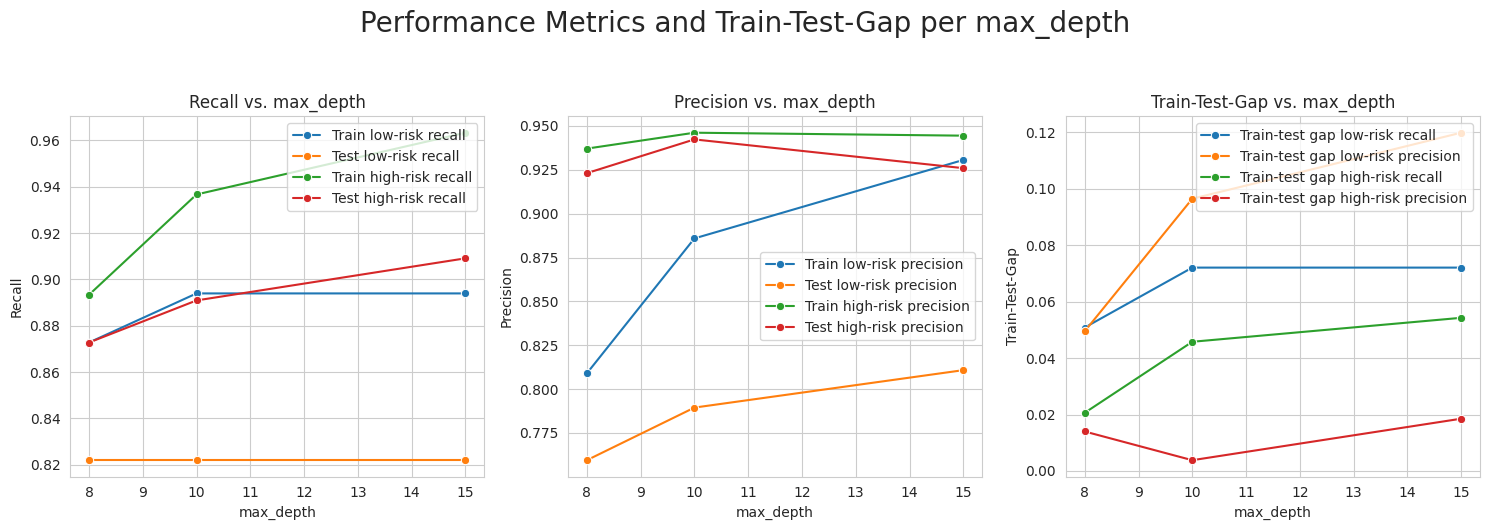

In [68]:
depths = [8, 10, 15]

sns.set_style("whitegrid")

fig_train_test_gap, axes = plt.subplots(1, 3, figsize=(15, 5), sharex=True)
fig_train_test_gap.suptitle(
                "Performance Metrics and Train-Test-Gap per max_depth",
                fontsize=20,
                y=1.05
                )

# Recall subplot
sns.lineplot(
        ax=axes[0],
        x=depths,
        y=report_max_depths["low risk"][report_max_depths.index.str.contains("recall_train")],  # noqa
        label="Train low-risk recall",
        marker="o"
        )
sns.lineplot(
        ax=axes[0],
        x=depths,
        y=report_max_depths["low risk"][report_max_depths.index.str.contains("recall_test")],  # noqa
        label="Test low-risk recall",
        marker="o"
        )
sns.lineplot(
        ax=axes[0],
        x=depths,
        y=report_max_depths["high risk"][report_max_depths.index.str.contains("recall_train")],  # noqa
        label="Train high-risk recall",
        marker="o"
        )
sns.lineplot(
        ax=axes[0],
        x=depths,
        y=report_max_depths["high risk"][report_max_depths.index.str.contains("recall_test")],  # noqa
        label="Test high-risk recall",
        marker="o"
        )
axes[0].set_xlabel('max_depth')
axes[0].set_ylabel('Recall')
axes[0].set_title('Recall vs. max_depth')

# Precision subplot
sns.lineplot(
        ax=axes[1],
        x=depths,
        y=report_max_depths["low risk"][report_max_depths.index.str.contains("precision_train")],  # noqa
        label="Train low-risk precision",
        marker="o"
        )
sns.lineplot(
        ax=axes[1],
        x=depths,
        y=report_max_depths["low risk"][report_max_depths.index.str.contains("precision_test")],  # noqa
        label="Test low-risk precision",
        marker="o"
        )
sns.lineplot(
        ax=axes[1],
        x=depths,
        y=report_max_depths["high risk"][report_max_depths.index.str.contains("precision_train")],  # noqa
        label="Train high-risk precision",
        marker="o"
        )
sns.lineplot(
        ax=axes[1],
        x=depths,
        y=report_max_depths["high risk"][report_max_depths.index.str.contains("precision_test")],  # noqa
        label="Test high-risk precision",
        marker="o"
        )
axes[1].set_xlabel('max_depth')
axes[1].set_ylabel('Precision')
axes[1].set_title('Precision vs. max_depth')

# Train-test-gap subplot
sns.lineplot(
        ax=axes[2],
        x=depths,
        y=report_max_depths["low risk"][report_max_depths.index.str.contains("recall_gap")],  # noqa
        label="Train-test gap low-risk recall",
        marker="o"
        )
sns.lineplot(
        ax=axes[2],
        x=depths,
        y=report_max_depths["low risk"][report_max_depths.index.str.contains("precision_gap")],  # noqa
        label="Train-test gap low-risk precision",
        marker="o"
        )
sns.lineplot(
        ax=axes[2],
        x=depths,
        y=report_max_depths["high risk"][report_max_depths.index.str.contains("recall_gap")],  # noqa
        label="Train-test gap high-risk recall",
        marker="o"
        )
sns.lineplot(
        ax=axes[2],
        x=depths,
        y=report_max_depths["high risk"][report_max_depths.index.str.contains("precision_gap")],  # noqa
        label="Train-test gap high-risk precision",
        marker="o"
        )
axes[2].set_xlabel('max_depth')
axes[2].set_ylabel('Train-Test-Gap')
axes[2].set_title('Train-Test-Gap vs. max_depth')


plt.tight_layout()
plt.show()

In [87]:
report_max_depths

,low risk,high risk
recall_train_d8,0.872727,0.893333
precision_train_d8,0.808989,0.937063
recall_test_d8,0.821918,0.872727
precision_test_d8,0.759494,0.923077
recall_gap_d8,0.050809,0.020606
precision_gap_d8,0.049495,0.013986
recall_train_d10,0.893939,0.936667
precision_train_d10,0.885886,0.946128
recall_test_d10,0.821918,0.890909
precision_test_d10,0.789474,0.942308


#### Train-Test-Gap Considerations

The plots above compare the results for max_depth of 8, 10 and 15. Note that we studied more parameters (including 7,9,12,13) but these did not lead to better results and did not add much to the analysis. So we decided to show the three most relevant ones here. Further, we did not only change the max_depth hyperparameter but conducted a detailed grid search for each of the max_depth values, optimizing the other hyperparameters for the model as well. Here we choose to focus on the discussion of max_depth since this shows very nicely the trade-offs between best performance and best generalizabilty when modelling the maternal health risk dataset. 

Summary with focus on high-risk recall (since this is the most important metric in our medical dataset):

* RandomForestClassifier with max_depth 8:
  * overall weaker performance but small train-test-gap
  * train set high-risk recall: 89%
  * test set high-risk recall: 87%
  * difference: 2 percentage points
  * The train-test-gap in low-risk precision is 5 percentage points
* RandomForestClassifier with max_depth 10:
  * better performance but also increased train-test-gap
  * train set high-risk recall: 94%
  * test set high-risk recall: 89%
  * difference: 5 percentage points
  * The train-test-gap in low-risk precision is 9.6 percentage points
* RandomForestClassifier with max_depth 15:
  * best performance (excellent high-risk recall) but largest train-test-gap
  * train set high-risk recall: 96%
  * test set high-risk recall: 91%
  * difference: 5 percentage points
  * The train-test-gap in low-risk precision is 12 percentage points

Each model could be suitable depending on the business case. In our case high-risk recall is very important, but the model should also generalize well.

The model with the best recall performance (max_depth=15) has a large train-test-gap, especially for low-risk precision, which has a gap of 12 percentage points. Low-risk precision is also very important in medical data, since high precision means that patients being classified as low-risk were indeed low-risk.

The model with the lowest recall performance (max_depth = 8) has a small test-train-gap which shows that it is the most robust model which could be very important in the medical field.

However, the model with max_depth 10 gives a good balance between generalization (gap in low-risk precision stays below 10) and recall performance (high-risk recall in the test set is 89%, which is very close to the 91% of the best performance model).


Note that we performed many more hyperparameter optimization searches and these are the most promising results we could find for our dataset.

 
#### Decision

We decide to build a pipeline with the RandomForestClassifier of max_depth 10 which is a model with very good recall and still acceptable train-test-gap (especially regarding our relatively small dataset).

### 8. Best Model with best Hyperparameters

Recall best model, best parameters and best pipeline:

* RandomForestClassification with hyperparameters:
  * 'model__max_depth': 10
  * 'model__max_leaf_nodes': None
  * 'model__min_samples_leaf': 1
  * 'model__min_samples_split': 2
  * 'model__n_estimators': 140

Note for future users:
The pipeline is saved in outputs and can be accessed directly with `joblib.load(filename=f'outputs/ml_pipeline/{version}/all_features/clf_pipeline_model.pkl')`, in case the above hyperparameter optimization is too detailed to go through

In [69]:
best_model_d10

'RandomForestClassifier'

In [70]:
best_parameters_d10

{'model__max_depth': 10,
 'model__max_leaf_nodes': None,
 'model__min_samples_leaf': 1,
 'model__min_samples_split': 2,
 'model__n_estimators': 140}

### Visualize Confusion matrix for best model:

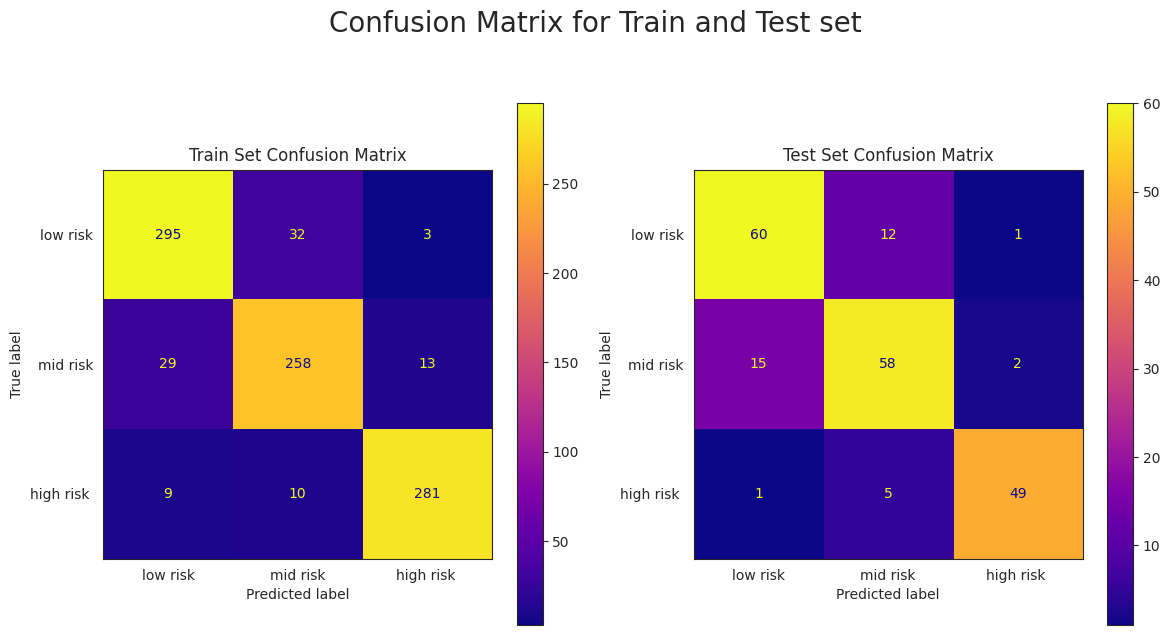

In [71]:
sns.set_style("white")
# Calculate confusion matrices
predictions_train = pipeline_clf_d10.predict(X_train)
predictions_test = pipeline_clf_d10.predict(X_test)
cm_train = confusion_matrix(
                y_train,
                predictions_train,
                labels=pipeline_clf_d10.classes_
                )
cm_test = confusion_matrix(
                y_test,
                predictions_test,
                labels=pipeline_clf_d10.classes_
                )

# Plot confusion matrices
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
fig.suptitle("Confusion Matrix for Train and Test set", fontsize=20, y=1.05)

disp_train = ConfusionMatrixDisplay(
                confusion_matrix=cm_train,
                display_labels=["low risk", "mid risk", "high risk "]
                )
disp_train.plot(ax=axes[0], values_format='d', cmap="plasma")
axes[0].set_title("Train Set Confusion Matrix")

disp_test = ConfusionMatrixDisplay(
                confusion_matrix=cm_test,
                display_labels=["low risk", "mid risk", "high risk "]
                )
disp_test.plot(ax=axes[1], values_format='d', cmap="plasma")
axes[1].set_title("Test Set Confusion Matrix")

plt.tight_layout()
plt.show()

## Push Files to Repo

We generate the following files:

* Train set
* Test set
* Features Engineering Pipeline
* Modeling Pipeline (note that we will continue looking at feature selection and refit the pipeline in the next notebook)
* Train-Test-Gap Plot to documentation/plots

These outputs are used in part B of this notebook and are not needed for the final dashboard deployment. Therefore, we add the folder outputs/ml_pipeline/{version}/all_features to .slugignore

In [72]:
version = 'v1'
file_path = f'outputs/ml_pipeline/{version}/all_features'

try:
    os.makedirs(name=file_path)
except Exception as e:
    print(e)

# save plots for documentation
try:
    os.makedirs("documentation/plots")
except Exception as e:
    print(e)

[Errno 17] File exists: 'outputs/ml_pipeline/v1/all_features'
[Errno 17] File exists: 'documentation/plots'


### Train Set

The data is transformed already with the feature engineering pipeline and SMOTE applied.

In [73]:
print(X_train.shape)
X_train.head()

(930, 5)


,Age,SystolicBP,BloodSugar,BodyTemp,HeartRate
0,2.562881,3667.547753,0.556858,37.8,70
1,2.850816,3667.547753,0.563778,38.3,76
2,2.485992,2621.220233,0.555252,36.7,76
3,3.182922,4871.954434,0.565231,36.7,90
4,2.802700,3667.547753,0.556311,36.7,70


In [74]:
X_train.to_csv(f"{file_path}/X_train.csv", index=False)

In [75]:
y_train.head()

0    1
1    1
2    0
3    2
4    0
Name: RiskLevel, dtype: int64

In [76]:
y_train.to_csv(f"{file_path}/y_train.csv", index=False)

### Test Set

The data is transformed already with the feature engineering pipeline and SMOTE applied.

In [77]:
print(X_test.shape)
X_test.head()

(203, 5)


,Age,SystolicBP,BloodSugar,BodyTemp,HeartRate
801,2.525557,3667.547753,0.556809,36.7,70
311,2.957047,2158.748161,0.556311,36.7,75
85,2.485992,2158.748161,0.556311,36.7,70
435,2.957047,4871.954434,0.565231,36.7,70
204,2.350874,1580.923565,0.559034,36.7,77


In [78]:
X_test.to_csv(f"{file_path}/X_test.csv", index=False)

In [79]:
y_test.head()

801    1
311    0
85     1
435    2
204    0
Name: RiskLevel, dtype: int64

In [80]:
y_test.to_csv(f"{file_path}/y_test.csv", index=False)

### ML Pipeline: Feature Engineering Pipeline

The pipeline that is responsible for winsorizing, Box-Cox tranforming and smart correlated selection of the data.

For new data this pipeline should be used in conjunction with the modelling pipeline when used on real data.

For train and test set we only use the model pipeline because the data is already preprocessed.

In [81]:
pipeline_feat_eng

Pipeline(steps=[('Winsorizer',
                 Winsorizer(capping_method='iqr', fold=1.5, tail='both',
                            variables=['BloodSugar', 'SystolicBP'])),
                ('BoxCoxTransformation',
                 BoxCoxTransformer(variables=['Age', 'SystolicBP',
                                              'BloodSugar'])),
                ('SmartCorrelatedSelection',
                 SmartCorrelatedSelection(method='spearman',
                                          selection_method='variance',
                                          threshold=0.6))])

In [82]:
joblib.dump(
        value=pipeline_feat_eng,
        filename=f"{file_path}/clf_pipeline_feat_eng.pkl"
        )

['outputs/ml_pipeline/v1/all_features/clf_pipeline_feat_eng.pkl']

### ML Pipeline: Model Pipeline

The pipeline that is responsible for scaling, feature selection and model. Note that we will continue looking at the features selected in the next notebook.

In [83]:
pipeline_clf_d10

Pipeline(steps=[('scaler', StandardScaler()),
                ('feat_selection',
                 SelectFromModel(estimator=RandomForestClassifier(random_state=0))),
                ('model',
                 RandomForestClassifier(max_depth=10, n_estimators=140,
                                        random_state=0))])

In [84]:
joblib.dump(
        value=pipeline_clf_d10,
        filename=f"{file_path}/clf_pipeline_model.pkl"
        )

['outputs/ml_pipeline/v1/all_features/clf_pipeline_model.pkl']

### Train-Test-Set-Gap

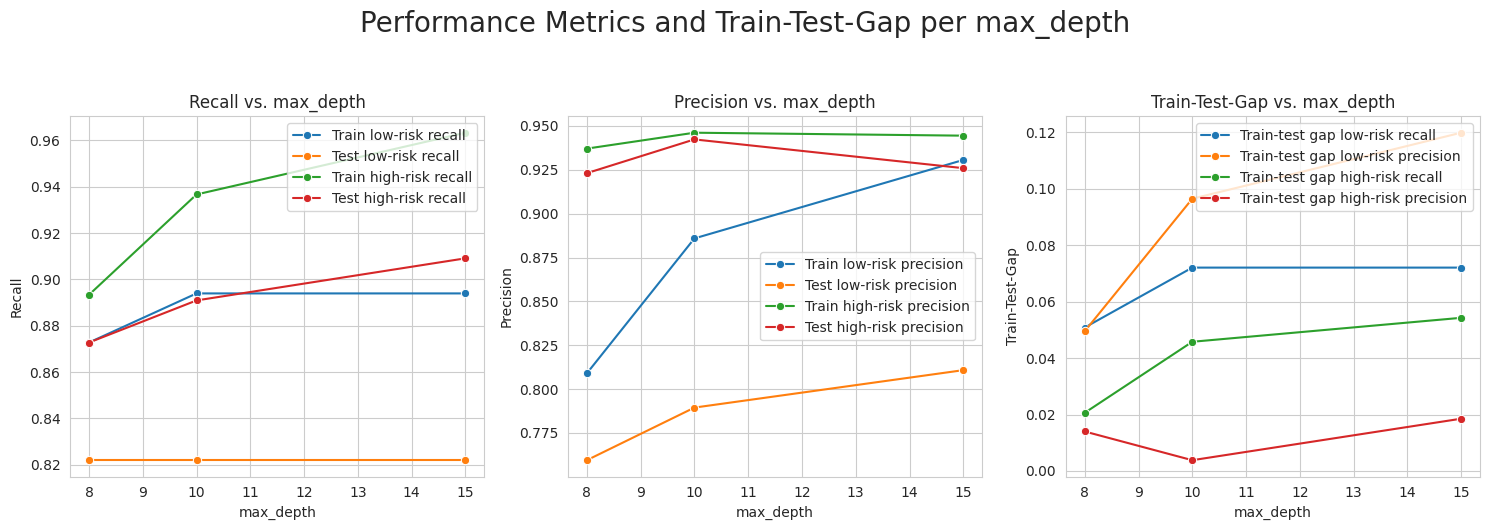

In [85]:
fig_train_test_gap

In [86]:
fig_train_test_gap.savefig(
            'documentation/plots/train-test-gap-per-depth.png',
            bbox_inches='tight'
            )

# Conclusions

In this notebook we:

* Fit the feature engineering pipeline to the train set and transformed the train and test set
* We then performed sample rebalancing with SMOTE
* We then performed an extensive hyperparameter optimization search which led to the conclusion that a RandomForestClassifier is the best algorithm for our data
* We did a detailed analysis of hyperparameter optimization for RandomForest to find a balance between high recall performance and good generalizability
* We decided on a RandomForestClassifier with max_depth=10 and visualised the performance metrics
* We saved the following files to outputs:
  * transformed train and test sets
  * feature engineering pipeline
  * modeling pipeline (fitted with all features)
  * plot visualizing the train-test-gap by max_depth


In the next notebook we will look at feature importance for our model and refit the pipelines with the best features only.